In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage.util import random_noise
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import random
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 512
img_cols = 640

smooth = 1.

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [6]:
batch_size = 32
epochs = 30
target_size = (512,640)

metrics=[dice_coef, 'acc',Jaccard_index, Specificity, Sensitivity, precision, recall, f1score]

sgd_opt = SGD(lr=1E-2, decay=1E-4, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4)

In [7]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

In [8]:
seed = 1
batch_size=10
train_image_generator = train_image_datagen.flow_from_directory(
    'data/training/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data/training/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
train_generator = zip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'data/validation/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/validation/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
val_generator = zip(val_image_generator, val_mask_generator)

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [9]:
from keras.models import *
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate


def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return Model(input=inputs, output=path)


In [10]:
input_shape = (512,640,1)
model = build_res_unet(input_shape=input_shape)
model.summary()
model.compile(optimizer=adam_opt, loss=dice_coef_loss, metrics= metrics)
model_checkpoint = ModelCheckpoint('models/endovis-Deep-Residual-Unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 640, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 640, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 512, 640, 64) 128         input_1[0][0]                    
__________________________________________________________________________________________________
activation

/home/sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [13]:
num_train_samples= len(train_image_generator.filenames)
num_train_samples

2

In [14]:
num_val_samples= len(val_image_generator.filenames)
num_val_samples

2

In [15]:
experiment_name = "Endovis-UNet"
img_dim = (512,640,1)
dataset='Endovis'
model_name = "Deep-Residual-UNet-Adam"

In [16]:
history = model.fit_generator(train_generator,
                 steps_per_epoch =int(np.ceil(num_train_samples * 1.0 / batch_size)),
                 validation_data = val_generator,
                 validation_steps=int(np.ceil(num_val_samples * 1.0 / batch_size)),
                 callbacks=[model_checkpoint],
                 epochs=epochs)

Epoch 1/5
1/1 [==============================] - 125s 125s/step - loss: -0.9841 - dice_coef: 0.9841 - acc: 0.2982 - Jaccard_index: 0.9688 - Specificity: -38.0029 - Sensitivity: 0.8071 - precision: 0.9235 - recall: 0.9980 - f1score: 0.9593 - val_loss: -1.1412 - val_dice_coef: 1.1412 - val_acc: 0.2148 - val_Jaccard_index: 1.3289 - val_Specificity: -32.4086 - val_Sensitivity: 0.8127 - val_precision: 0.8337 - val_recall: 0.9978 - val_f1score: 0.9084

Epoch 00001: loss improved from inf to -0.98415, saving model to models/endovis-Deep-Residual-Unet.hdf5
Epoch 2/5
1/1 [==============================] - 139s 139s/step - loss: -0.9536 - dice_coef: 0.9536 - acc: 0.2723 - Jaccard_index: 0.9112 - Specificity: -37.4492 - Sensitivity: 0.8727 - precision: 0.8172 - recall: 0.9959 - f1score: 0.8978 - val_loss: -1.2080 - val_dice_coef: 1.2080 - val_acc: 0.2006 - val_Jaccard_index: 1.5251 - val_Specificity: -31.8178 - val_Sensitivity: 0.8071 - val_precision: 0.7607 - val_recall: 0.9794 - val_f1score: 0.

In [17]:
history.history["val_loss"]

[-1.1412392854690552,
 -1.207964301109314,
 -1.197577953338623,
 -1.331838846206665,
 -1.4764082431793213]

In [18]:
history.history["val_dice_coef"]

[1.1412392854690552,
 1.207964301109314,
 1.197577953338623,
 1.331838846206665,
 1.4764082431793213]

In [19]:
history.history["val_acc"]

[0.21481171250343323,
 0.200633242726326,
 0.2749481201171875,
 0.20961761474609375,
 0.13670197129249573]

In [20]:
history.history["val_Jaccard_index"]

[1.328937292098999,
 1.5251386165618896,
 1.492454171180725,
 1.993289589881897,
 2.819770097732544]

In [21]:
history.history["loss"]

[-0.9841489195823669,
 -0.953559160232544,
 -1.2600764036178589,
 -1.3714269399642944,
 -1.4309630393981934]

In [22]:
history.history["dice_coef"]

[0.9841489195823669,
 0.953559160232544,
 1.2600764036178589,
 1.3714269399642944,
 1.4309630393981934]

In [23]:
history.history["acc"]

[0.29817962646484375,
 0.272317498922348,
 0.2107894867658615,
 0.20056915283203125,
 0.1687057465314865]

In [24]:
history.history["Jaccard_index"]

[0.9687924981117249,
 0.9112403988838196,
 1.702981948852539,
 2.1818103790283203,
 2.5147101879119873]

In [25]:
score = model.evaluate_generator(val_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  -1.4764082860946655
Test Accuracy:  1.4764082860946655


In [26]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 147.64%


In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'val_acc', 'val_Jaccard_index', 'val_Specificity', 'val_Sensitivity', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'dice_coef', 'acc', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score'])


In [30]:
test_imgs = val_image_generator.next()
test_masks = val_mask_generator.next()
# Let's visualize some of the outputs 
predictions = model.predict_on_batch(test_imgs)

IndexError: index 2 is out of bounds for axis 0 with size 2

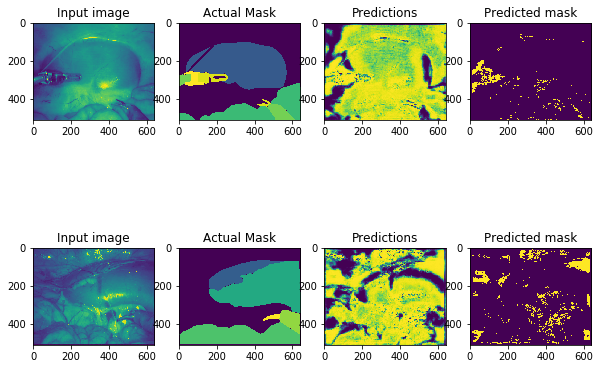

In [31]:
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    img = test_imgs[i,:,:,0]
    label = test_masks[i,:,:,0]
    predicted_label = predictions[i,:,:,0]

    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label)
    plt.title("Actual Mask")
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label)
    plt.title("Predictions")
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(predicted_label>0.99)
    plt.title("Predicted mask")
    
plt.show()

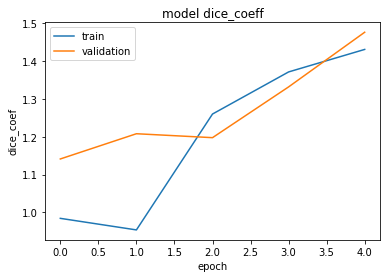

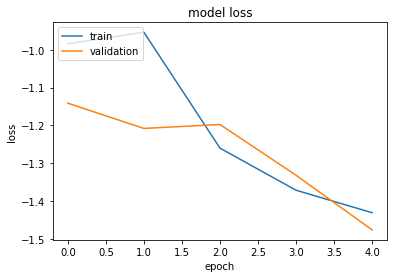

In [32]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

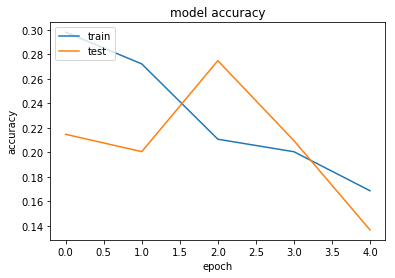

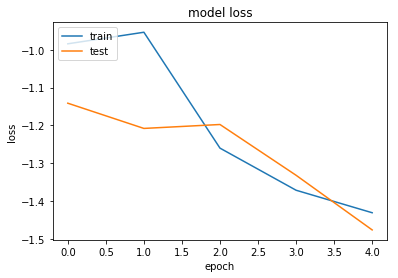

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

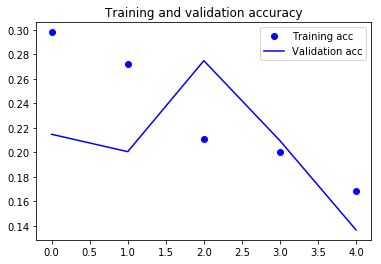

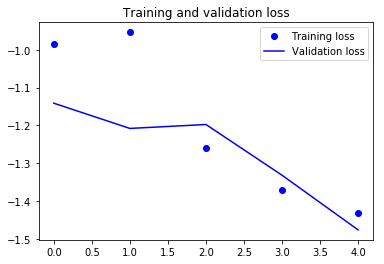

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

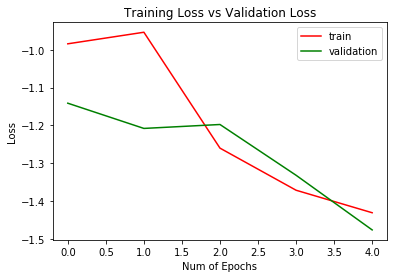

In [35]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')

plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [38]:
prediction = model.predict_generator(val_generator, verbose=1, steps=10)

10/10 [==============================] - 266s 27s/step


In [39]:
prediction

array([[[[1.6950378e-01],
         [2.4227031e-02],
         [5.8845212e-03],
         ...,
         [4.1787385e-05],
         [3.9799568e-05],
         [1.9571111e-05]],

        [[5.2313503e-02],
         [1.1143698e-02],
         [3.5950472e-03],
         ...,
         [6.3393013e-06],
         [4.1375464e-05],
         [1.6453917e-04]],

        [[5.7789072e-02],
         [5.0577544e-02],
         [2.5803851e-02],
         ...,
         [1.1603900e-05],
         [2.4546401e-04],
         [5.3195463e-04]],

        ...,

        [[4.7143824e-02],
         [5.3188939e-02],
         [1.5053202e-02],
         ...,
         [9.4910824e-01],
         [9.7846621e-01],
         [9.3100768e-01]],

        [[4.7223736e-02],
         [2.6165696e-02],
         [2.0669905e-02],
         ...,
         [6.6194326e-01],
         [8.4401220e-01],
         [9.3713987e-01]],

        [[7.8271301e-03],
         [5.0547076e-03],
         [3.1368064e-03],
         ...,
         [8.2128227e-01],
        

In [40]:
len(prediction)

20

In [41]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
#         io.imsave(os.path.join(save_path, str(image_id) + '_pred.png'), img)

In [42]:
saveResult('results_dir6',prediction)

/home/sara/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [43]:
# https://github.com/danielelic/deep-hands/blob/59517243823372af4be154ee1f622fcb119f0c59/train_inception-v3.py
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 147.64%


In [44]:
print("%s: %.2f%%" % (model.metrics_names[0], score[1] * 100))

loss: 147.64%


In [45]:
for i in range(1, len(model.metrics_names)):
    print("\nResults validating with training data: %s: %.2f%%" % (model.metrics_names[i], score[i]*100))


Results validating with training data: dice_coef: 147.64%

Results validating with training data: acc: 13.67%

Results validating with training data: Jaccard_index: 281.98%

Results validating with training data: Specificity: -2875.35%

Results validating with training data: Sensitivity: 86.15%

Results validating with training data: precision: 62.01%

Results validating with training data: recall: 96.46%

Results validating with training data: f1score: 75.49%


In [46]:
model.save('models/EndoVis-Deep-Residual-Unet-Adam-Model.h5')
model.save_weights('models/EndoVis-Deep-Residual-Unet-Adam-Weights.h5')

___

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results_dir6/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# https://www.kaggle.com/pestipeti/explanation-of-scoring-metric

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from scipy import ndimage
from pathlib import Path

img= plt.imread("data/training/images/ISIC_0000000.jpg")
target_mask = plt.imread("results_dir6/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")


# Plot the objects
# plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)

fig, axes = plt.subplots(1,3, figsize=(16,9))
axes[0].imshow(img)
axes[1].imshow(target_mask,cmap='jet')
axes[2].imshow(pred_mask, cmap='jet')

labels = ['Original', '"GroundTruth" Mask', '"Predicted" Mask']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

In [ ]:
import numpy as np


def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.", "image1 shape:", im1.shape,"image2 shape:", im2.shape)

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [ ]:
groundTruth = plt.imread("results_dir6/prediction_0_69_pred.jpg")
resultImage = plt.imread("data/augmented/image_0_10533.png")

In [ ]:
resultImage = (resultImage - resultImage.min()) / (resultImage.max() - resultImage.min())
groundTruth = (groundTruth - groundTruth.min()) / (groundTruth.max() - groundTruth.min())

In [ ]:
dice(resultImage, groundTruth)

In [ ]:
resultImage.shape

In [ ]:
groundTruth.shape

In [ ]:
groundTruth.ndim , groundTruth.ndim

In [ ]:
target_mask = plt.imread("results_dir6/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")

In [ ]:
A = target_mask
B = pred_mask
intersection = np.logical_and(A, B)
union = np.logical_or(A, B)

fig, axes = plt.subplots(1,4, figsize=(18,12))
axes[0].imshow(A, cmap='hot')
axes[0].annotate('npixels = {}'.format(np.sum(A>0)), 
                 xy=(10, 10), color='white', fontsize=12)
axes[1].imshow(B, cmap='hot')
axes[1].annotate('npixels = {}'.format(np.sum(B>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[2].imshow(intersection, cmap='hot')
axes[2].annotate('npixels = {}'.format(np.sum(intersection>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[3].imshow(union, cmap='hot')
axes[3].annotate('npixels = {}'.format(np.sum(union>0)), 
                 xy=(10, 10), color='white', fontsize=12)

labels = ['GroundTruth', 'Predicted', 'Intersection', 'Union']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)

In [ ]:
def histdata(accuracy):
    numvalues, x = np.histogram(accuracy, bins=np.arange(0,1.1,0.1))
    print("Accuracy  :   No. of predictions\n")
    for i in range(len(numvalues)):
        print("{:03.1f} - {:03.1f} : {:>4}".format(x[i],x[i+1],numvalues[i]))

In [ ]:
histdata(prediction)

In [ ]:
print("Mean Accuracy:",np.mean(prediction))
print("Accuracy > 0.8 :", np.mean(prediction>=0.8)*100,"%")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

target_mask = plt.imread("results_dir6/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")

gt = np.asarray(target_mask).astype(np.bool)
pred = np.asarray(pred_mask).astype(np.bool)

intersection = np.logical_and(gt, pred)
print("Dice score: " + str(2. * intersection.sum() / (gt.sum() + pred.sum())))

print("precision: " + str(precision_score(gt.flatten(), pred.flatten())))
print("accuracy: " + str(accuracy_score(gt.flatten(), pred.flatten())))
print("recall: " + str(recall_score(gt.flatten(), pred.flatten())))
print("f1 (Dice): " + str(f1_score(gt.flatten(), pred.flatten())))